longitude/latitude
array([[0.04713115, 0.00394786],
       [0.08412929, 0.03277073],
       [0.12535445, 0.01958159],
       [0.10554705, 0.01363236],
       [0.10273201, 0.06390272]])
6  Depots


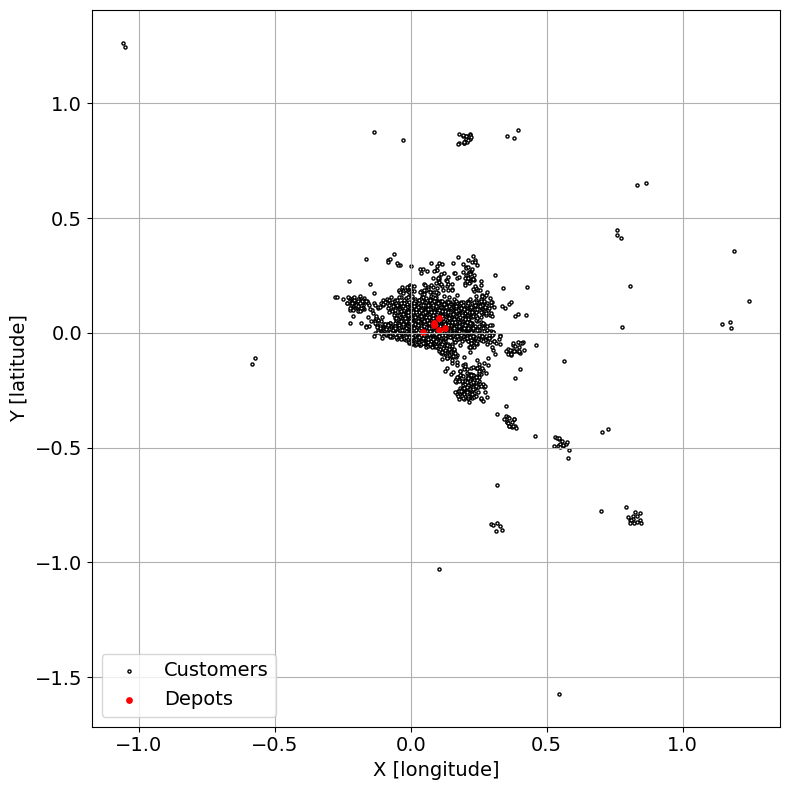

In [2]:
# import requests
from pprint import pprint
import matplotlib.pyplot as plt
import time
import json
from custom_tools_max.data_input import get_2828_instance

nodes, _, _= get_2828_instance()
print("longitude/latitude")
pprint(nodes[:5])

# Unzip the list of tuples into x and y coordinates
x, y = zip(*nodes)

nodes_x, nodes_y = x[6:], y[6:]
depots_x, depots_y = x[:6], y[:6]

print(len(depots_x)," Depots")
# Create a scatter plot

plt.figure(figsize=(8,8))  # Set the figure size
# Plot all points with alpha=0.2 for customers
plt.scatter(nodes_x, nodes_y, facecolor='white', edgecolor='black',marker='o',s=5, alpha=1, label='Customers')

# Highlight the first data point (depot) as a solid black dot
plt.scatter(depots_x, depots_y, color='red', marker='o',s=15, alpha=1, label='Depots')


plt.xlabel('X [longitude]',fontsize=14)
plt.ylabel('Y [latitude]',fontsize=14)
# plt.tick_params(size=20)
plt.tick_params(axis='both', labelsize=14) 
# plt.legend()
plt.legend(loc='lower left',fontsize=14) #, bbox_to_anchor=(0.5, -0.1), ncol=2)  # Adjust 'ncol' to change the number of columns
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# trying to snap the mountain remote locations (wtf)
# 2236 (1 based)
# 2235 (0 based)
# 25.904273,-100.510541

# 2421 (1 based)
# 2420 (0 based)
# 25.8872493,-100.618161


from sensitive_data.osc_api_key import MOB as OSC_API_KEY
import requests
# longitude/latitude
all_nodes = [[longitude,latitude] for longitude,latitude in nodes]

print("The locations to be snapped as array of longitude/latitude pairs.")
body = {"locations":[all_nodes[2235],all_nodes[2420]], "radius":5500}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': OSC_API_KEY,
    'Content-Type': 'application/json; charset=utf-8'
}
call = requests.post('https://api.openrouteservice.org/v2/snap/driving-car', json=body, headers=headers)

print(call.status_code, call.reason)

call.text

import json
from pprint import pprint
snapped_exceptions_dict = json.loads(call.text)
pprint(snapped_exceptions_dict)

violently_snapped_2235 = snapped_exceptions_dict['locations'][0]['location']
violently_snapped_2420 = snapped_exceptions_dict['locations'][1]['location']
snapped_distance_2235 = snapped_exceptions_dict['locations'][0]['snapped_distance']
snapped_distance_2420 = snapped_exceptions_dict['locations'][1]['snapped_distance']
print(violently_snapped_2235)
print(violently_snapped_2420)
# Replace the remote location with snapped locations

print("\nbefore")
pprint(all_nodes[2234:2237])
pprint(all_nodes[2419:2422])

all_nodes[2235] = violently_snapped_2235
all_nodes[2420] = violently_snapped_2420

print("after")
pprint(all_nodes[2234:2237])
pprint(all_nodes[2419:2422])

# looks ok

In [ ]:

# Limitations provided by OSM
max_calls_per_minute = 40
retry_delays = [2, 8, 16, 32, 64]
retry_attempts = 5
call_times = []
nodes_to_fetch = []
if nodes_to_fetch:
    for run in nodes_to_fetch:

        current_time = time.time()
        call_times = [t for t in call_times if current_time - t < 60]  # Keep calls within the last minute

        # If we've made too many calls, wait
        if len(call_times) >= max_calls_per_minute:
            wait_time = 60 - (current_time - call_times[0])  # Calculate how long to wait
            print(f"Rate limit exceeded. Waiting for {wait_time:.2f} seconds.")
            time.sleep(wait_time)
        
        # Add current call time
        call_times.append(time.time())

        # standard call to generate columns without addresses 
        # body = {
        #     "locations": all_nodes,"destinations":[run],"metrics":["distance","duration"]
        #     }

        # The call to fix the missing rows
        body = {
            "locations": all_nodes,
            "sources": [run],
            "metrics":["distance","duration"]
            }

        headers = {
            'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
            'Authorization': OSC_API_KEY,
            'Content-Type': 'application/json; charset=utf-8'
        }
        success = False
        for attempt in range(retry_attempts):
            call = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)
            print(call.status_code, call.reason)

            if call.status_code // 100 == 2:  # Check for successful response
                success = True
                # Convert JSON string to Python dictionary
                data_dict = call.json()
                # pprint(data_dict)

                # filename = f"OSM_data/matrix_cache_exploit_call_{run}.json"
                filename = f"OSM_data_fix/row_based_fix{run}.json"

                # Write the dictionary to a JSON file
                with open(filename, 'w') as json_file:
                    json.dump(data_dict, json_file, indent=4)
                print(f"API call {run} successfull ...")
                break  # Exit retry loop if successful
            else:
                # If the call fails, print the error and wait before retrying
                print(f"API call failed. Attempt {attempt + 1} of {retry_attempts}. Retrying in {retry_delays[attempt]} seconds...")
                time.sleep(retry_delays[attempt])

        if not success:
            print(f"Failed to get a valid response after {retry_attempts} attempts for run {run}.")



In [ ]:
# MERGE THE VECTORS
import pandas as pd
duration_cache_dfs = []
distance_cache_dfs = []
for cache_index in range(0,2828):
    with open(f"OSM_data/matrix_cache_exploit_call_{cache_index}.json", 'r') as json_file:
        data_loaded = json.load(json_file)
        duration_cache_dfs.append(pd.Series([n[0] for n in data_loaded['durations']]))
        distance_cache_dfs.append(pd.Series([n[0] for n in data_loaded['distances']]))
        

duration_df = pd.concat(duration_cache_dfs, axis=1)
distance_df = pd.concat(distance_cache_dfs, axis=1)

# fix problematic rows
for row_to_fix in [2235,2420]:
    with open(f"OSM_data_fix/row_based_fix{row_to_fix}.json", 'r') as json_file:
        data_loaded = json.load(json_file)
        duration_df.iloc[row_to_fix] = data_loaded["durations"][0]
        distance_df.iloc[row_to_fix] = data_loaded["distances"][0]

display(duration_df)
display(duration_df.info())

display(distance_df)
display(distance_df.info())

In [ ]:
# duration_df.to_csv(r"matrices_2828/time_matrix_2828.csv", sep=",", header=False, index=False)
# distance_df.to_csv(r"matrices_2828/distance_matrix_2828.csv", sep=",", header=False, index=False)

# Start Matrix Edit Here


In [1]:
import pandas as pd
from custom_tools_max.data_input import FILE_DISTANCE, FILE_DURATION

distance_df = pd.read_csv(FILE_DISTANCE, header = None)
duration_df = pd.read_csv(FILE_DURATION, header = None)

display(distance_df)
display(duration_df)

,0,1,2,3,4,5,6,7,8,9,...,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827
0,0.00,11029.99,12489.44,9603.43,10229.53,5871.20,15795.75,22797.09,106366.30,10318.69,...,6345.35,6979.38,22193.24,3620.03,6203.69,8732.66,7048.94,11411.27,6861.85,7643.93
1,9650.12,0.00,3708.74,5815.51,11277.10,5059.86,24154.28,17073.89,107436.61,6699.27,...,12937.50,15337.91,17762.31,9481.22,11993.14,10738.02,11969.52,9328.20,12187.41,12590.12
2,11413.93,2617.02,0.00,5391.79,11944.70,6823.66,25918.08,15144.06,108104.21,7695.12,...,13933.36,17101.71,18758.16,11245.02,12988.99,11733.88,12965.37,10324.05,13183.26,13585.97
3,9868.57,4348.46,5619.79,0.00,12936.76,4523.89,24377.19,20047.08,109096.27,2114.62,...,9420.21,15560.82,13177.66,9225.10,8477.77,7222.66,8454.15,4743.55,8672.04,9074.75
4,11686.40,9436.72,11327.24,15643.37,0.00,10465.81,20159.30,16271.98,96687.07,16358.63,...,15948.96,17323.92,27421.67,13223.65,15807.30,16557.24,16652.56,19243.75,16465.47,17247.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,8435.06,10318.17,11589.49,6641.44,15096.78,7847.75,22943.68,26016.78,111132.02,6509.78,...,5960.96,14127.31,14909.88,7791.59,4135.87,0.00,4024.50,4127.91,4242.39,4645.10
2824,6615.39,11722.17,12993.50,8045.44,16316.89,9251.75,21124.02,27420.79,112453.66,8515.61,...,3687.84,12307.65,16915.71,5971.92,1703.02,3443.92,0.00,6133.74,2020.17,2391.19
2825,9737.13,12305.32,13576.64,8628.59,19438.63,9834.90,24245.75,28003.93,115575.40,6189.50,...,7263.03,15429.38,12407.71,9093.66,5437.94,3105.74,5326.68,0.00,5544.58,5947.28
2826,6129.42,11745.83,13017.15,8069.10,15830.91,9512.83,20638.04,27444.44,111967.68,8784.36,...,2489.86,11821.67,17642.33,5631.70,664.77,4181.75,1510.02,6860.36,0.00,2105.01


,0,1,2,3,4,5,6,7,8,9,...,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827
0,0.00,813.88,1003.20,708.66,793.72,521.62,1186.72,1676.85,4959.15,726.80,...,505.57,517.08,1305.21,343.33,448.13,591.91,552.81,664.42,591.79,563.08
1,726.35,0.00,373.67,440.94,915.22,391.29,1759.63,1218.69,5234.19,466.70,...,776.41,1089.99,1066.35,773.91,760.12,719.50,827.65,711.92,861.42,839.72
2,961.24,311.88,0.00,528.11,1035.12,626.18,1994.52,1095.52,5354.10,640.91,...,950.63,1324.88,1240.56,1008.80,934.33,893.71,1001.87,886.13,1035.63,1013.94
3,620.53,313.10,405.01,0.00,996.64,374.31,1649.08,1264.22,5315.62,220.51,...,615.45,979.44,820.16,658.41,614.51,573.89,682.04,465.73,715.81,694.12
4,903.64,770.88,1034.19,1027.68,0.00,736.60,1623.26,1323.05,4431.66,1045.83,...,1135.77,1243.77,1645.48,973.53,1078.32,1131.53,1183.01,1239.49,1221.98,1193.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,566.52,741.07,832.97,514.98,1184.28,668.03,1595.07,1692.18,5384.24,523.95,...,464.87,925.43,948.41,604.40,323.04,0.00,389.01,307.62,422.78,401.08
2824,512.74,834.71,926.61,608.62,1186.73,761.67,1541.29,1785.82,5352.15,626.35,...,333.42,871.66,1050.82,550.62,205.32,314.88,0.00,410.03,249.54,229.54
2825,543.15,796.64,888.55,570.55,1217.14,723.60,1571.70,1747.76,5382.56,491.15,...,441.50,902.06,778.67,581.03,299.67,220.93,393.66,0.00,427.43,405.73
2826,539.92,916.72,1008.62,690.63,1213.91,845.70,1568.47,1867.83,5379.33,708.78,...,269.12,898.83,1156.73,566.02,127.29,443.43,231.97,515.95,0.00,242.24


In [136]:
duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Columns: 2828 entries, 0 to 2827
dtypes: float64(2828)
memory usage: 61.0 MB


In [2]:
import numpy as np
durations_np = duration_df.to_numpy()
distance_np = distance_df.to_numpy()
velocities_np = np.round((distance_df/1000) / (duration_df/(60*60)),0)
print(velocities_np)

      0     1     2     3     4     5     6     7     8     9     ...  2818  \
0      NaN  49.0  45.0  49.0  46.0  41.0  48.0  49.0  77.0  51.0  ...  45.0   
1     48.0   NaN  36.0  47.0  44.0  47.0  49.0  50.0  74.0  52.0  ...  60.0   
2     43.0  30.0   NaN  37.0  42.0  39.0  47.0  50.0  73.0  43.0  ...  53.0   
3     57.0  50.0  50.0   NaN  47.0  44.0  53.0  57.0  74.0  35.0  ...  55.0   
4     47.0  44.0  39.0  55.0   NaN  51.0  45.0  44.0  79.0  56.0  ...  51.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2823  54.0  50.0  50.0  46.0  46.0  42.0  52.0  55.0  74.0  45.0  ...  46.0   
2824  46.0  51.0  50.0  48.0  49.0  44.0  49.0  55.0  76.0  49.0  ...  40.0   
2825  65.0  56.0  55.0  54.0  57.0  49.0  56.0  58.0  77.0  45.0  ...  59.0   
2826  41.0  46.0  46.0  42.0  47.0  40.0  47.0  53.0  75.0  45.0  ...  33.0   
2827  45.0  50.0  50.0  46.0  49.0  43.0  49.0  55.0  75.0  48.0  ...  44.0   

      2819  2820  2821  2822  2823  2824  2825  282

In [4]:
average = np.nanmean(velocities_np)
average

55.45455270974018

In [5]:
# print(durations_np[:6,:].max()/60)
df1 = pd.DataFrame(np.round(durations_np[:6, :].T / 60, 0))
stats_outgoing = df1.describe(percentiles=[0.25,0.5,0.95,0.96,0.97,0.98,0.99,0.997]).round(2)
print("Outgoing")
print(stats_outgoing)

df2 = pd.DataFrame(np.round(durations_np[:, :6] / 60, 0))
stats_incoming = df2.describe(percentiles=[0.25,0.5,0.95,0.96,0.97,0.98,0.99,0.997]).round(2)
print("Incoming")
print(stats_incoming)

Outgoing
             0        1        2        3        4        5
count  2828.00  2828.00  2828.00  2828.00  2828.00  2828.00
mean     20.97    21.01    22.73    19.92    23.25    19.97
std      17.97    17.27    17.08    17.18    17.18    17.42
min       0.00     0.00     0.00     0.00     0.00     0.00
25%      10.00    12.00    13.00    10.00    14.00    10.00
50%      16.00    16.00    18.00    16.00    20.00    15.00
95%      42.65    43.00    46.00    42.00    47.00    42.00
96%      49.00    46.00    48.00    44.00    51.00    46.00
97%      58.71    59.38    59.19    58.00    62.00    58.76
98%      82.00    86.00    85.00    87.00    74.00    83.00
99%     102.19   100.19    99.00    97.00   100.46    99.38
99.7%   145.05   145.94   145.82   142.42   145.71   144.49
max     247.00   251.00   254.00   248.00   257.00   248.00
Incoming
             0        1        2        3        4        5
count  2828.00  2828.00  2828.00  2828.00  2828.00  2828.00
mean     20.94    20.1

In [6]:
from custom_tools_max.data_input import FILE_TW
tw_df = pd.read_json(FILE_TW).transpose().reset_index(drop=True)
tw_df.rename(columns={"Lower Window (min)":"e_i","Upper window (min)":"l_i"},inplace=True)
# display(tw_df)

grouped = tw_df.groupby(["e_i","l_i"]).size().reset_index(name="Count")
grouped["Relative Percentage (%)"] = (grouped["Count"] / len(tw_df))
grouped["Cumulative Probability"] = grouped["Relative Percentage (%)"].cumsum()
# display(grouped)

In [7]:
threshold_97_percentile_outgoing = df1.max(axis=1).quantile(0.97)
threshold_97_percentile_incoming = df2.max(axis=1).quantile(0.97)
print(threshold_97_percentile_outgoing)
print(threshold_97_percentile_incoming)
most_distant_indices_outgoing = df1[df1.max(axis=1) >= threshold_97_percentile_outgoing].index.tolist()
most_distant_indices_incoming = df2[df2.max(axis=1) >= threshold_97_percentile_incoming].index.tolist()

print(most_distant_indices_outgoing)
print(most_distant_indices_incoming)
most_distant_indices = set(most_distant_indices_outgoing).union(set(most_distant_indices_incoming))
print(most_distant_indices)

67.19000000000005
66.19000000000005
[8, 481, 493, 505, 792, 831, 845, 847, 849, 860, 896, 945, 949, 950, 952, 957, 960, 961, 963, 966, 971, 977, 989, 996, 998, 1019, 1023, 1046, 1063, 1151, 1156, 1197, 1229, 1231, 1315, 1316, 1510, 1562, 1600, 1618, 1637, 1652, 1717, 1718, 1734, 1764, 1788, 1799, 1885, 1954, 1992, 1993, 2046, 2047, 2140, 2170, 2205, 2227, 2235, 2237, 2256, 2306, 2329, 2330, 2333, 2342, 2349, 2351, 2352, 2401, 2420, 2434, 2561, 2579, 2708, 2757, 2765, 2771, 2773, 2774, 2776, 2777, 2780, 2782, 2789]
[8, 357, 481, 493, 505, 792, 831, 845, 847, 849, 860, 896, 945, 949, 950, 952, 957, 960, 963, 966, 971, 977, 989, 996, 998, 1019, 1023, 1046, 1063, 1151, 1156, 1197, 1229, 1231, 1315, 1316, 1510, 1562, 1600, 1618, 1637, 1652, 1717, 1718, 1734, 1764, 1788, 1799, 1885, 1954, 1992, 1993, 2046, 2047, 2140, 2170, 2205, 2227, 2235, 2237, 2256, 2306, 2329, 2330, 2333, 2342, 2349, 2351, 2352, 2401, 2420, 2434, 2561, 2579, 2708, 2757, 2765, 2771, 2773, 2774, 2776, 2777, 2780, 2782, 27

In [8]:
distanced_nodes_time_windows = grouped[(grouped["e_i"]<226) & (grouped["l_i"]>257)].copy(deep=True)
print(distanced_nodes_time_windows)
depot_tw = grouped[(grouped["e_i"]==0) & (grouped["l_i"]==480)].copy(deep=True)

    e_i  l_i  Count  Relative Percentage (%)  Cumulative Probability
1     0  420      3                 0.010676                0.014235
2     0  480      2                 0.007117                0.021352
7   120  270      1                 0.003559                0.241993
8   120  300      1                 0.003559                0.245552
10  150  270      3                 0.010676                0.259786
12  180  300     13                 0.046263                0.316726
13  180  330      1                 0.003559                0.320285
14  180  360      7                 0.024911                0.345196
15  180  390      1                 0.003559                0.348754
16  180  420      6                 0.021352                0.370107
17  180  450     22                 0.078292                0.448399
18  180  480      1                 0.003559                0.451957
19  195  330      1                 0.003559                0.455516
20  210  270      3               

In [214]:
# pd.set_option('display.max_rows', None)
# final_node_time_windows.iloc[list(most_distant_indices)].head(86)

,Node,"tw(e_i,l_i)"
2561,2561,"(0, 480)"
8,8,"(0, 480)"
2579,2579,"(0, 480)"
1046,1046,"(0, 480)"
1562,1562,"(0, 480)"
1023,1023,"(0, 480)"
1063,1063,"(0, 480)"
1600,1600,"(0, 480)"
1618,1618,"(0, 480)"
2140,2140,"(0, 480)"


In [9]:
node_time_windows = [None] * 2828
for depot_idx in range(6):
    node_time_windows[depot_idx] = (0, 480)
node_time_windows

# Function to sample time windows based on their relative probabilities
def sample_time_window(grouped_df):
    random_value = np.random.random()
    for _, row in grouped_df.iterrows():
        if random_value <= row["Cumulative Probability"]:
            return (int(row["e_i"]), int(row["l_i"]))
    # Fallback: Return the most probable time window if no match is found
    return (int(grouped_df.iloc[-1]["e_i"]), int(grouped_df.iloc[-1]["l_i"]))

# Assign time windows to all nodes
for idx in range(len(node_time_windows)):
    if idx in range(6):
        continue  # Skip depots as they are already assigned
    elif idx in most_distant_indices:
        # Sample from distanced_nodes_time_windows for most distant nodes
        node_time_windows[idx] = (0,480) #sample_time_window(distanced_nodes_time_windows)
    else:
        # Sample from the overall grouped time windows
        node_time_windows[idx] = sample_time_window(grouped)

In [16]:
final_node_time_windows = pd.DataFrame({
    "Node": range(2828),
    "tw(e_i,l_i)": node_time_windows
})
final_node_time_windows_check = final_node_time_windows.groupby(["tw(e_i,l_i)"]).size().reset_index(name="Count")
final_node_time_windows_check["Relative Percentage (%)"] = round(final_node_time_windows_check["Count"]*100 / len(final_node_time_windows),2)
final_node_time_windows_check["p_r original"] = round(grouped["Relative Percentage (%)"]*100,2)
final_node_time_windows_check.sort_values("Count",ascending=False).reset_index(drop=True)

,"tw(e_i,l_i)",Count,Relative Percentage (%),p_r original
0,"(120, 240)",587,20.76,19.93
1,"(300, 480)",353,12.48,12.81
2,"(300, 420)",307,10.86,11.03
3,"(360, 480)",279,9.87,11.03
4,"(180, 450)",219,7.74,7.83
5,"(240, 360)",160,5.66,6.05
6,"(210, 330)",159,5.62,6.05
7,"(180, 300)",126,4.46,4.63
8,"(0, 480)",120,4.24,0.71
9,"(300, 360)",57,2.02,2.14


,Node,"tw(e_i,l_i)"
2561,2561,"(210, 330)"
8,8,"(120, 270)"
2579,2579,"(210, 330)"
1046,1046,"(120, 270)"
1562,1562,"(210, 330)"
...,...,...
493,493,"(210, 330)"
505,505,"(180, 450)"
1019,1019,"(210, 330)"
2046,2046,"(180, 450)"


In [215]:

final_node_time_windows.to_json("tw2828_removed_outliers.json")

In [99]:
type(final_node_time_windows["tw(e_i,l_i)"].tolist()[0])

tuple

In [107]:
from custom_tools_max.data_input import FILE_TW
tw = pd.read_json(FILE_TW,dtype=tuple)

In [112]:
tw["tw(e_i,l_i)"].to_list()

[[0, 480],
 [0, 480],
 [0, 480],
 [0, 480],
 [0, 480],
 [0, 480],
 [300, 480],
 [60, 180],
 [210, 330],
 [360, 420],
 [180, 450],
 [180, 420],
 [300, 480],
 [240, 420],
 [240, 360],
 [300, 420],
 [120, 240],
 [240, 360],
 [210, 330],
 [300, 480],
 [300, 480],
 [210, 330],
 [120, 240],
 [300, 480],
 [300, 480],
 [360, 480],
 [120, 240],
 [300, 420],
 [300, 360],
 [300, 480],
 [300, 480],
 [180, 450],
 [300, 480],
 [120, 240],
 [120, 240],
 [120, 240],
 [210, 330],
 [120, 240],
 [300, 480],
 [120, 240],
 [120, 240],
 [0, 420],
 [180, 300],
 [300, 480],
 [0, 480],
 [180, 390],
 [300, 480],
 [300, 480],
 [180, 450],
 [360, 480],
 [360, 480],
 [60, 180],
 [180, 450],
 [315, 390],
 [180, 450],
 [120, 240],
 [120, 240],
 [120, 240],
 [180, 450],
 [120, 240],
 [300, 480],
 [60, 180],
 [300, 420],
 [120, 240],
 [180, 450],
 [300, 420],
 [120, 240],
 [300, 420],
 [120, 240],
 [300, 480],
 [210, 270],
 [300, 420],
 [300, 480],
 [300, 480],
 [360, 480],
 [120, 240],
 [360, 480],
 [300, 360],
 [180

In [131]:
tw_all.max().max()

480

In [ ]:
# Check rows

# Assuming you have a DataFrame called df and the indices you want to display are:
# indices = list(range(2234, 2237)) + list(range(2419, 2422))

# # Select rows corresponding to these indices using iloc
# subset_df_duration = duration_df.iloc[indices]
# subset_df_distance = distance_df.iloc[indices]

# Display the resulting subset of the DataFrame
# The result is not nice xd
"""
0        1        2        3        4        5        6        7     \
2234  1660.26  2050.74  2329.97  2094.11  1675.96  1803.03   743.41  1862.92   
2235      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2236  2313.78  2726.78  2818.68  2500.69  2582.09  2596.93  1381.46  2628.39   
2419   779.56   340.14   413.09   177.42  1036.94   507.68  1808.11  1291.26   
2420      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2421  1531.60   863.91   982.03  1164.23  1197.57  1255.21  2385.16   274.87   

         8        9     ...     2818     2819     2820     2821     2822  \
2234  4957.29  2112.26  ...  1892.39  1233.35  2692.03  1730.14  1834.94   
2235      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
2236  5722.75  2518.83  ...  2091.58  1871.41  3118.49  2235.79  2228.64   
2419  5355.92   354.73  ...   753.60  1138.47   912.63   817.44   737.31   
2420      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
2421  4818.22  1189.99  ...  1499.70  1890.51  1789.64  1569.48  1483.41   

         2823     2824     2825     2826     2827  
2234  1978.72  1939.62  2051.24  1978.60  1949.89  
2235      NaN      NaN      NaN      NaN      NaN  
2236  2411.99  2265.58  2484.51  2378.06  2200.59  
2419   696.69   804.84   549.22   838.61   816.91  
2420      NaN      NaN      NaN      NaN      NaN  
2421  1442.79  1550.94  1435.21  1584.71  1563.02  

[6 rows x 2828 columns]
          0         1         2         3         4         5         6     \
2234  22139.31  28466.57  30965.14  30208.03  23054.08  25030.46   8918.86   
2235       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2236  33425.79  52973.48  54244.80  49296.75  46793.14  48648.63  19853.75   
2419  11621.69   3756.81   4452.78   1829.75  11755.86   5545.83  26130.31   
2420       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2421  25559.71  12307.70  12767.19  17989.06  13618.79  17367.56  49597.29   

          7          8         9     ...      2818      2819      2820  \
2234  38625.27  107837.77  30923.29  ...  26401.87  16479.14  42249.76   
2235       NaN        NaN       NaN  ...       NaN       NaN       NaN   
2236  57919.51  127132.01  50012.01  ...  42455.14  27414.03  61075.05   
2419  19455.42  107915.37   3536.92  ...  11237.25  17313.95  13767.20   
2420       NaN        NaN       NaN  ...       NaN       NaN       NaN   
2421   3941.94  104860.04  18872.82  ...  25111.05  31251.96  29935.86   

          2821      2822      2823      2824      2825      2826      2827  
2234  23676.55  26260.21  28789.18  27105.46  31467.79  26918.38  27700.45  
2235       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2236  43494.45  44083.99  47266.98  44731.87  49945.59  44953.41  44282.46  
2419  10978.22  10292.88   9037.77  10269.26   5761.91  10487.16  10889.86  
2420       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2421  24916.24  24166.68  22911.57  24143.06  21501.75  24360.96  24763.67  

[6 rows x 2828 columns]
"""
# #
# print("\nROWS\n")
# print(subset_df_duration)
# print(subset_df_distance)


ROWS

         0        1        2        3        4        5        6        7     \
2234  1660.26  2050.74  2329.97  2094.11  1675.96  1803.03   743.41  1862.92   
2235  4548.75  4502.79  4757.58  4672.79  3947.72  4381.71  4213.23  4099.65   
2236  2313.78  2726.78  2818.68  2500.69  2582.09  2596.93  1381.46  2628.39   
2419   779.56   340.14   413.09   177.42  1036.94   507.68  1808.11  1291.26   
2420  4417.98  5034.71  5216.17  4898.18  4704.87  4768.19  3485.67  4751.16   
2421  1531.60   863.91   982.03  1164.23  1197.57  1255.21  2385.16   274.87   

         8        9     ...     2818     2819     2820     2821     2822  \
2234  4957.29  2112.26  ...  1892.39  1233.35  2692.03  1730.14  1834.94   
2235  7124.56  4690.94  ...  4780.88  4552.67  5290.59  4618.64  4723.44   
2236  5722.75  2518.83  ...  2091.58  1871.41  3118.49  2235.79  2228.64   
2419  5355.92   354.73  ...   753.60  1138.47   912.63   817.44   737.31   
2420  7845.53  4916.33  ...  4489.07  3975.61  5461.

In [63]:
# Check columns
# results
"""
2234  2235     2236     2419  2420     2421
0     1399.36   NaN  2332.49   808.80   NaN  1496.22
1     1942.65   NaN  2575.38   413.69   NaN   980.18
2     2175.41   NaN  2749.60   427.77   NaN   857.01
3     1861.72   NaN  2414.42   190.93   NaN  1025.71
4     1315.95   NaN  2356.31  1082.36   NaN  1108.19
...       ...   ...      ...      ...   ...      ...
2823  1807.71   NaN  2391.75   639.03   NaN  1453.67
2824  1753.93   NaN  2307.85   732.67   NaN  1547.31
2825  1784.34   NaN  2368.37   694.60   NaN  1509.25
2826  1781.11   NaN  2243.55   814.68   NaN  1629.32
2827  1798.06   NaN  2174.49   776.79   NaN  1591.44

[2828 rows x 6 columns]
          2234  2235      2236      2419  2420      2421
0     19334.92   NaN  45583.74   9367.56   NaN  19812.09
1     26066.03   NaN  52329.21   4566.07   NaN  13355.17
2     27834.99   NaN  53325.07   4375.71   NaN  11425.34
3     27916.37   NaN  48811.92   2041.10   NaN  16328.37
4     22714.91   NaN  42933.83  11007.29   NaN  13188.48
...        ...   ...       ...       ...   ...       ...
2823  26482.85   NaN  47223.83   8111.52   NaN  22298.07
2824  24663.19   NaN  45075.99   9515.52   NaN  23702.08
2825  27784.92   NaN  48525.90  10098.67   NaN  24285.22
2826  24177.21   NaN  43878.00   9539.18   NaN  23725.73
2827  25031.35   NaN  43826.90   9883.69   NaN  24070.24

[2828 rows x 6 columns]
"""
# That's a problem
# print("\nCOLUMNS\n")
# subset_df_1 = duration_df.iloc[:, list(range(2234, 2237)) + list(range(2419, 2422))]
# print(subset_df_1)
# subset_df_2 = distance_df.iloc[:, list(range(2234, 2237)) + list(range(2419, 2422))]
# print(subset_df_2)




COLUMNS

         2234     2235     2236     2419     2420     2421
0     1399.36  4198.73  2332.49   808.80  4456.22  1496.22
1     1942.65  4545.39  2575.38   413.69  4961.30   980.18
2     2175.41  4665.29  2749.60   427.77  5135.51   857.01
3     1861.72  4565.77  2414.42   190.93  4800.34  1025.71
4     1315.95  3742.86  2356.31  1082.36  4448.18  1108.19
...       ...      ...      ...      ...      ...      ...
2823  1807.71  4623.82  2391.75   639.03  4777.67  1453.67
2824  1753.93  4591.73  2307.85   732.67  4693.77  1547.31
2825  1784.34  4622.14  2368.37   694.60  4754.29  1509.25
2826  1781.11  4618.91  2243.55   814.68  4629.47  1629.32
2827  1798.06  4635.86  2174.49   776.79  4560.40  1591.44

[2828 rows x 6 columns]
          2234      2235      2236      2419      2420      2421
0     19334.92  49614.39  45583.74   9367.56  55218.13  19812.09
1     26066.03  51562.41  52329.21   4566.07  76018.02  13355.17
2     27834.99  52230.01  53325.07   4375.71  77013.88  11425.

In [13]:
# Snapped distances
import json
from pprint import pprint
import numpy as np
with open(f"sensitive_data/matrix_cache_exploit_call_2420.json", 'r') as json_file:
    data_loaded_for_snaps = json.load(json_file)
snapped_locations = [l['location'] if (type(l) != type(None)) else [-100,25] for l  in data_loaded_for_snaps['sources'] ]
# snapped_locations[2235] = violently_snapped_2235
# snapped_locations[2420] = violently_snapped_2420 

import matplotlib.pyplot as plt
%matplotlib tk

# Assuming nodes and snapped_locations are provided as lists of longitude/latitude pairs
# nodes: original nodes, snapped_locations: snapped nodes corresponding to the original ones

print("The locations to be snapped as array of longitude/latitude pairs.")
print("longitude/latitude")
nodes, _, _= get_2828_instance()
pprint(nodes[:5])

# Unzip the list of tuples into x and y coordinates
nodes_modified = nodes - nodes[0]
nodes_x, nodes_y = zip(*nodes_modified)

# nodes_x, nodes_y = x[6:], y[6:]
# depots_x, depots_y = x[:6], y[:6]
print(len(depots_x), " Depots")

# Unzip the snapped_locations
snapped_loc_modfied = np.array(snapped_locations) - np.array(snapped_locations[0])


snapped_x, snapped_y = zip(*snapped_loc_modfied)

plt.figure(figsize=(12, 12))  # Set the figure size

dot_size = 25

# Plot all points with alpha=0.2 for customers
plt.scatter(nodes_x, nodes_y, facecolor='white', edgecolor='black', marker='o', s=dot_size, alpha=1, label='Default Node Position')

# # Highlight the depots as red dots
# plt.scatter(depots_x, depots_y, color='red', marker='o', s=dot_size, alpha=1, label='Depots')

# Plot snapped locations as blue circles
plt.scatter(snapped_x, snapped_y, color='black', marker='o', s=dot_size, alpha=1, label='Snapped Node Position')

# Draw a red line connecting each original node to its corresponding snapped location
for i in range(len(nodes)):
    plt.plot([nodes_x[i], snapped_x[i]], [nodes_y[i], snapped_y[i]], color='black', linewidth=0.5)
# Draw arrows connecting original nodes to snapped locations
# for i in range(len(nodes)):
#     plt.arrow(
#         nodes_x[i], nodes_y[i],  # Start point
#         snapped_x[i] - nodes_x[i], snapped_y[i] - nodes_y[i],  # Direction (dx, dy)
#         color='black', width=0.0005, head_width=0.005, length_includes_head=True, alpha=0.7
#     )


plt.xlabel('x [longitude]')
plt.ylabel('y [latitude]')
# plt.xticks([])
# plt.yticks([])

# Display legend and grid
# plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.legend()
plt.grid(True)

# Show plot
plt.show()

The locations to be snapped as array of longitude/latitude pairs.
longitude/latitude
array([[ 0.00814331,  0.01838516],
       [ 0.09356768,  0.00131755],
       [ 0.1293968 , -0.0138763 ],
       [ 0.10628407, -0.01591749],
       [ 0.09914771,  0.08181672]])
6  Depots


count    2828.000000
mean       36.444501
std       118.255485
min         0.020000
25%         6.807500
50%        13.005000
75%        21.680000
max      2537.570000
dtype: float64


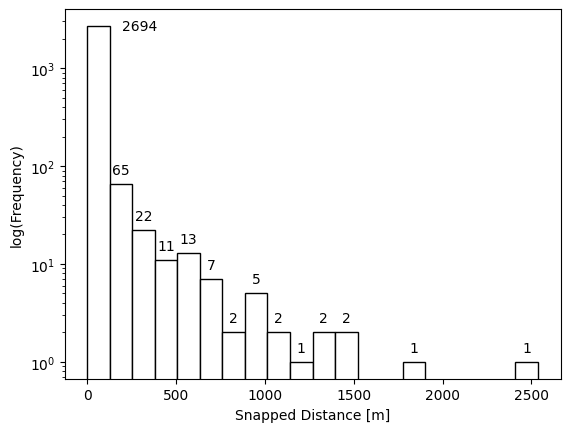

In [31]:
snapped_distances = pd.Series([source["snapped_distance"] if (type(source) != type(None)) else 0 for source in data_loaded_for_snaps["sources"] ])
snapped_distances[2235] = snapped_distance_2235
snapped_distances[2420] = snapped_distance_2420

%matplotlib inline
print(snapped_distances.describe())

import matplotlib.pyplot as plt

ax = snapped_distances.hist(bins=20, log=True, color='white', edgecolor='black',grid=False)  # White bars with black outline

# Adding counts above each bar
for i,p in enumerate(ax.patches):
    if i == 0:
        ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(30, 0), textcoords='offset points')
    else:
        ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# plt.title('Histogram Snapped Distances')
plt.xlabel('Snapped Distance [m]')
plt.ylabel('log(Frequency)')
plt.show()

In [126]:
tw1 = [(1,2),(3,4),(3,4),(3,4),(3,4)]
tw1[:2] = [(1, 1), (3, 3)]
print(tw1)

[(1, 1), (3, 3), (3, 4), (3, 4), (3, 4)]


In [188]:
stats_outgoing = df1.describe(percentiles=[0.25,0.5,0.95,0.96,0.97,0.98,0.99,0.9999]).round(2)
print(stats_outgoing)
stats_incoming = df2.describe(percentiles=[0.25,0.5,0.95,0.96,0.97,0.98,0.99,0.9999]).round(2)
print(stats_incoming)

              0        1        2        3        4        5
count   2828.00  2828.00  2828.00  2828.00  2828.00  2828.00
mean      20.97    21.01    22.73    19.92    23.25    19.97
std       17.97    17.27    17.08    17.18    17.18    17.42
min        0.00     0.00     0.00     0.00     0.00     0.00
25%       10.00    12.00    13.00    10.00    14.00    10.00
50%       16.00    16.00    18.00    16.00    20.00    15.00
95%       42.65    43.00    46.00    42.00    47.00    42.00
96%       49.00    46.00    48.00    44.00    51.00    46.00
97%       58.71    59.38    59.19    58.00    62.00    58.76
98%       82.00    86.00    85.00    87.00    74.00    83.00
99%      102.19   100.19    99.00    97.00   100.46    99.38
99.99%   222.69   227.25   229.97   225.38   230.99   223.97
max      247.00   251.00   254.00   248.00   257.00   248.00
              0        1        2        3        4        5
count   2828.00  2828.00  2828.00  2828.00  2828.00  2828.00
mean      20.94    20.10

In [193]:
durations_cutoff = duration_df.copy()
durations_cutoff = (durations_cutoff/60).round(0).astype("int64")
d_np = durations_cutoff.to_numpy()

modifiable_mask = np.zeros(durations_cutoff.shape, dtype=bool)
modifiable_mask[:, :6] = True
modifiable_mask[:6, :] = True

d_np = np.where(modifiable_mask, np.clip(d_np, None, 230), d_np)

df11 = pd.DataFrame(d_np[:6, :].T)
stats_outgoing = df11.describe(percentiles=[0.25,0.5,0.95,0.96,0.97,0.98,0.99,0.997]).round(2)
print("Outgoing")
print(stats_outgoing)

df22 = pd.DataFrame(d_np[:, :6])
stats_incoming = df22.describe(percentiles=[0.25,0.5,0.95,0.96,0.97,0.98,0.99,0.997]).round(2)
print("Incoming")
print(stats_incoming)

Outgoing
             0        1        2        3        4        5
count  2828.00  2828.00  2828.00  2828.00  2828.00  2828.00
mean     20.96    21.00    22.72    19.91    23.24    19.96
std      17.91    17.17    16.98    17.11    17.06    17.35
min       0.00     0.00     0.00     0.00     0.00     0.00
25%      10.00    12.00    13.00    10.00    14.00    10.00
50%      16.00    16.00    18.00    16.00    20.00    15.00
95%      42.65    43.00    46.00    42.00    47.00    42.00
96%      49.00    46.00    48.00    44.00    51.00    46.00
97%      58.71    59.38    59.19    58.00    62.00    58.76
98%      82.00    86.00    85.00    87.00    74.00    83.00
99%     102.19   100.19    99.00    97.00   100.46    99.38
99.7%   145.05   145.94   145.82   142.42   145.71   144.49
max     231.00   231.00   231.00   231.00   231.00   231.00
Incoming
             0        1        2        3        4        5
count  2828.00  2828.00  2828.00  2828.00  2828.00  2828.00
mean     20.94    20.0